In [0]:
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, resnet50

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
import numpy as np
import json

In [5]:
!pip install foolbox
import foolbox
from foolbox.models import PyTorchModel
from foolbox.attacks import L2BasicIterativeAttack
from foolbox.criteria import Misclassification, ConfidentMisclassification, TargetClassProbability

## Open ImageNet labels

Load .json file with text description for each label in the ImageNet data set.

In [7]:
from google.colab import files
uploaded = files.upload()

with open("imagenet1000_clsidx_to_labels.json") as f:
    imagenet_labels = json.load(f)
    
    # Keys in json file always stored as strings, so fore the ease of use lets convert them to integer values
    imagenet_labels = {int(k): v for k, v in imagenet_labels.items()}

Saving imagenet1000_clsidx_to_labels.json to imagenet1000_clsidx_to_labels (1).json


In [8]:
#print first 12 labels
for label in list(imagenet_labels)[:12]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")
    
print("...")

#print last 12 labels
for label in list(imagenet_labels)[-12:]:
    print(f"Label {label:3d} : {imagenet_labels[label]}")

Label   0 : tench, Tinca tinca
Label   1 : goldfish, Carassius auratus
Label   2 : great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
Label   3 : tiger shark, Galeocerdo cuvieri
Label   4 : hammerhead, hammerhead shark
Label   5 : electric ray, crampfish, numbfish, torpedo
Label   6 : stingray
Label   7 : cock
Label   8 : hen
Label   9 : ostrich, Struthio camelus
Label  10 : brambling, Fringilla montifringilla
Label  11 : goldfinch, Carduelis carduelis
...
Label 988 : acorn
Label 989 : hip, rose hip, rosehip
Label 990 : buckeye, horse chestnut, conker
Label 991 : coral fungus
Label 992 : agaric
Label 993 : gyromitra
Label 994 : stinkhorn, carrion fungus
Label 995 : earthstar
Label 996 : hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa
Label 997 : bolete
Label 998 : ear, spike, capitulum
Label 999 : toilet tissue, toilet paper, bathroom tissue


## Load ImageNet pretrained ResNet 18, 50

In [0]:
model18 = resnet18(pretrained=True).eval().to(device)
model50 = resnet50(pretrained=True).eval().to(device)

## Data normalization function


In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [0]:
# Create a Transform object from the list of all transformations we want to do
transform = transforms.Compose(
    [
        # resize image to 299 pixels in width and hight
        transforms.Resize((299,299)),
        
        # transorm "Image" object to "tensor" onject. Used when working with PIL.Image
        transforms.ToTensor(),
        
        # Normalize image per chanel
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ]
)                                      

## Upload Target Image

In [11]:
# upload panda
uploaded = files.upload()

Saving panda.jpg to panda (1).jpg


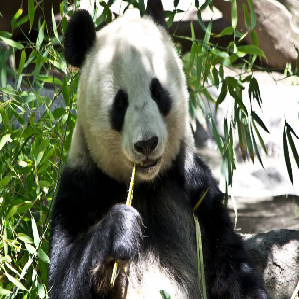

In [12]:
# Open image with PIL.Image
initial_image = Image.open("panda.jpg")

# Resize image
initial_image = initial_image.resize((299, 299))

# Jupyter supports drawing of PIL.Image if it`s a last row of a cell 
initial_image

## Restore normalized image function

In [0]:
def restore_image(image):
    # Move chanel axis [3, 299, 299] -> [299, 299, 3]
    new_image = np.rollaxis(np.rollaxis((image), 2), 2)
    
    # Multiply by std and add mean
    new_image = (new_image * std) + mean
    
    # Move from range 0-1 to the range 0-255
    new_image = new_image * 255
    
    # Make sure to remove all values that lower that 0 or higher than 255
    # as it not valid images
    new_image = np.clip(new_image, 0, 255)
    
    # Put image to the "byte" format. 
    # That`s required by PIL.Image to be abble to restore image from numpy array
    new_image = new_image.astype(np.uint8)
    return new_image

## Generate & visualize adversarial functions

In [0]:
def generate_adversarial(model, attack, selected_criterion, image):
    foolbox_model = PyTorchModel(
        model, 
        bounds=(-4, +4), 
        num_classes=1000,
        channel_axis=1
    )
    attack = attack(
        model=foolbox_model,
        criterion=selected_criterion
    )
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    
    normalazed_input_numpy = normalized_image.cpu().numpy()
    predicted_labels = np.array([int(predicted_class)])

    new_images = attack(normalazed_input_numpy, labels=predicted_labels)
    
    restored_numpy_array = restore_image(new_images[0])
    restored_image = Image.fromarray(restored_numpy_array)
    return restored_image

In [0]:
def print_prediction(model, image):
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    predicted_class = prediction.argmax(-1).cpu().numpy()
    print(f"Predicted class {int(predicted_class)} : {imagenet_labels[int(predicted_class)]}")
    print(f"Probability: {torch.softmax(prediction, -1)[predicted_class]:.3f}")

## Task 1

Perform Adversarial on ResNet-50




### Perform a bunch of attacks

In [0]:
import foolbox.attacks as atk


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SinglePixelAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Predicted class 111 : nematode, nematode worm, roundworm
Probability: 0.064


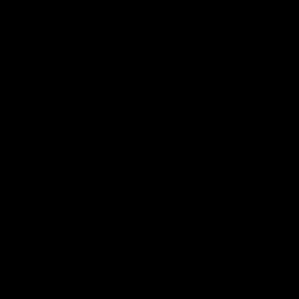

In [16]:
# Single Pixel
adv_image = generate_adversarial(
    model50,
    atk.SinglePixelAttack,
    Misclassification(), 
    initial_image
)
print_prediction(model50, adv_image)
adv_image

Predicted class 295 : American black bear, black bear, Ursus americanus, Euarctos americanus
Probability: 0.782


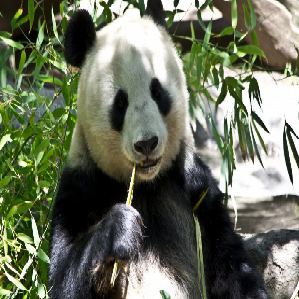

In [18]:
# DeepFool
adv_image = generate_adversarial(
    model50,
    atk.DeepFoolAttack,
    Misclassification(), 
    initial_image
)
print_prediction(model50, adv_image)
adv_image

Predicted class 666 : mortar
Probability: 0.991


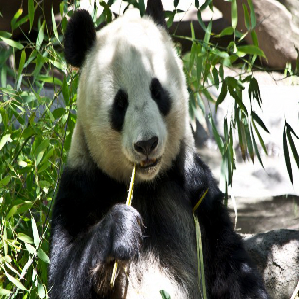

In [31]:
# PGD
adv_image = generate_adversarial(
    model50,
    atk.PGD,
    TargetClassProbability(666, 0.99), 
    initial_image
)
print_prediction(model50, adv_image)
adv_image

Predicted class 666 : mortar
Probability: 0.977


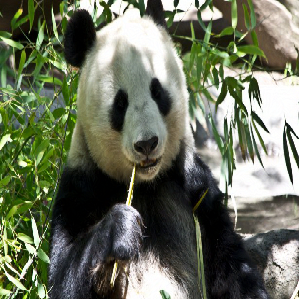

In [37]:
# Momentum Iterative
adv_image = generate_adversarial(
    model50,
    atk.MomentumIterativeAttack,
    TargetClassProbability(666, 0.99), 
    initial_image
)
print_prediction(model50, adv_image)
adv_image

Predicted class 666 : mortar
Probability: 0.981


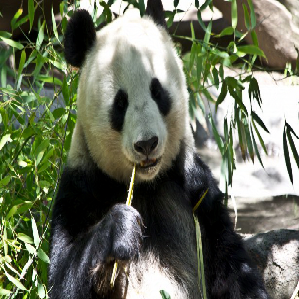

In [38]:
# L2 Basic Iterative
adv_image = generate_adversarial(
    model50,
    L2BasicIterativeAttack,
    TargetClassProbability(666, 0.99), 
    initial_image
)
print_prediction(model50, adv_image)
adv_image

### Visualize Mask

1. Black & White mask

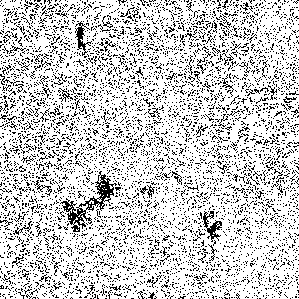

In [39]:
# Calculate the difference between initial and aversarial images
diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)

# Find all pixels where changes was done
diff_location = diff.mean(-1) != 0

# White - pixels where the was some pertirbations
Image.fromarray((diff_location*255).astype(np.uint8))

2. Colored mask

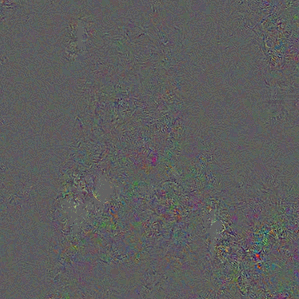

In [40]:
# For this we need to rescale all perturbations in the diapason 0-255
scaled_diff = diff - diff.min()
scaled_diff = scaled_diff / scaled_diff.max()
# Scaled difference between initial and adversarial image
Image.fromarray((scaled_diff*255).astype(np.uint8))

## Task 2

Compare required L1, L2 and L-infinity norms between attacks on ResNet-50 and ResNet-18. 

Compare results

### Calculate Norms

In [0]:
def three_norms(img1, img2):
    diff = np.array(img1).astype(int) - np.array(img2).astype(int)

    L1_norm = np.abs(diff).mean()
    L2_norm = np.sqrt((diff**2).mean())
    Linfinity_norm = np.abs(diff).max()

    print(f"L1 norm: {L1_norm}, L2 norm: {L2_norm}, L-infinity norm: {Linfinity_norm}")

In [0]:
m18_image = generate_adversarial(
    model18,  
    L2BasicIterativeAttack,
    TargetClassProbability(17, 0.95), 
    initial_image
)
m50_image = generate_adversarial(
    model50,  
    L2BasicIterativeAttack,
    TargetClassProbability(17, 0.95), 
    initial_image
)

In [24]:
# target & adv on resnet-18
three_norms(m18_image, initial_image)

L1 norm: 0.5595127571279963, L2 norm: 0.8139513652192625, L-infinity norm: 8


In [25]:
# target & adv on resnet-50
three_norms(m50_image, initial_image)

L1 norm: 0.5475889531437008, L2 norm: 0.7951125485786138, L-infinity norm: 6


In [26]:
# two adv images comparison
three_norms(m18_image, m50_image)

L1 norm: 0.6055189539266899, L2 norm: 0.8937257555788669, L-infinity norm: 9


### A bit of conclusions

These adversarial images were closer to each other, than to the target image at 2am. 

At 12am after one more run they are closer to the target. It was L-inf distance 3 between them, now it's 9. I had some conclusions tonight, now they are ruined.

Still, having $3\cdot 299\cdot 299$ tensors and these dist values, I must admit that images are veeery close to each other. 

### I also think it's worth plotting

In [0]:
def get_norm_lists(model, image):
    L1_norms = []
    L2_norms = []
    Linf_norms = []

    for target_probability in np.linspace(0.01, 0.99, 20):
        adv_image = generate_adversarial(
            model,  
            L2BasicIterativeAttack,
            TargetClassProbability(666, target_probability), 
            image
        )
        
        diff = np.array(adv_image).astype(int) - np.array(image).astype(int)
        
        L1_norms.append(np.abs(diff).mean())
        L2_norms.append(np.sqrt((diff**2).mean()))
        Linf_norms.append(np.abs(diff).max())

    return L1_norms, L2_norms, Linf_norms

Lets plot norms from ResNet-18 first

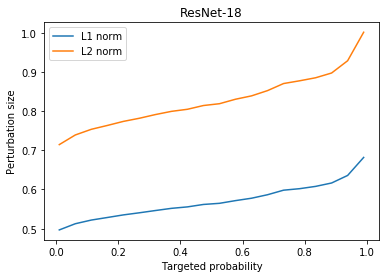

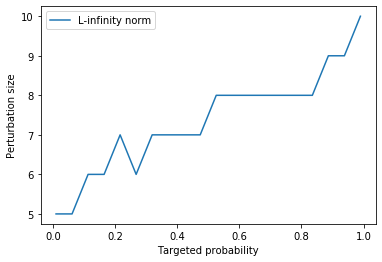

In [41]:
L1_18, L2_18, Linf_18 = get_norm_lists(model18, initial_image)

plt.plot(np.linspace(0.01, 0.99, 20), L1_18, label="L1 norm")
plt.plot(np.linspace(0.01, 0.99, 20), L2_18, label="L2 norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.title("ResNet-18")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), Linf_18, label="L-infinity norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

Then plot results on ResNet-50

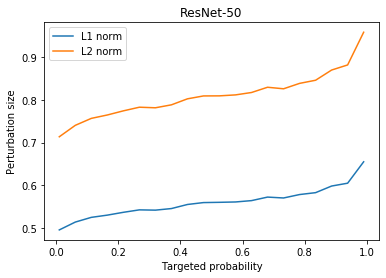

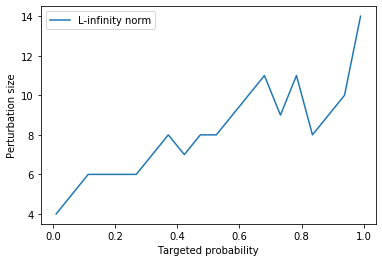

In [42]:
L1_50, L2_50, Linf_50 = get_norm_lists(model50, initial_image)

plt.plot(np.linspace(0.01, 0.99, 20), L1_50, label="L1 norm")
plt.plot(np.linspace(0.01, 0.99, 20), L2_50, label="L2 norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.title("ResNet-50")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), Linf_50, label="L-infinity norm")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

Now it's time to compare ResNet-18 and ResNet-50 norm by norm!

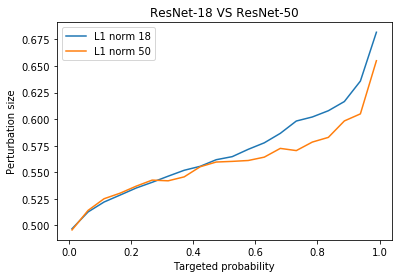

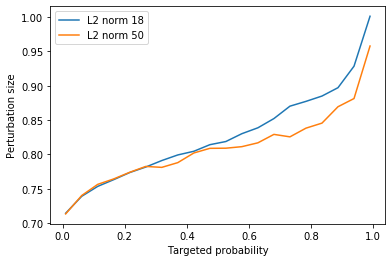

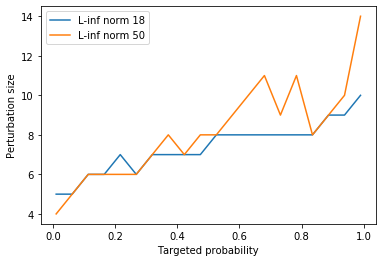

In [43]:
plt.plot(np.linspace(0.01, 0.99, 20), L1_18, label="L1 norm 18")
plt.plot(np.linspace(0.01, 0.99, 20), L1_50, label="L1 norm 50")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.title("ResNet-18 VS ResNet-50")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), L2_18, label="L2 norm 18")
plt.plot(np.linspace(0.01, 0.99, 20), L2_50, label="L2 norm 50")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

plt.plot(np.linspace(0.01, 0.99, 20), Linf_18, label="L-inf norm 18")
plt.plot(np.linspace(0.01, 0.99, 20), Linf_50, label="L-inf norm 50")
plt.legend()
plt.xlabel("Targeted probability")
plt.ylabel("Perturbation size")
plt.show()

### More conclusions

As I expected, for fooling ResNet-50 adversarial has to be a bit closer to the target, which is shown with L1 and L2 norms

Unfortunately, I am a bit bad at measure theory, so I can't analyze L-inf norm. The space is not even separable :(

## Task 3

Try new attacks. Use attacks from foolbox:
  - PGD
  - AdamPGD
  - DeepFoolAttack 
  
..or any other.

Find attack with lowest L-1 for the `Misclassification()` and `TargetClassProbability(666, 0.99)`. Not all of attacks will work in all cases, so dont panic, and just put marks about it.

In [0]:
def get_prediction(model, image):
    # get prediction
    normalized_image = transform(image).unsqueeze(0).to(device)
    prediction = model(normalized_image)[0]
    
    # get class, label & probability
    predicted_class = prediction.argmax(-1).cpu().numpy()
    label =  imagenet_labels[int(predicted_class)]
    probability = torch.softmax(prediction, -1)[predicted_class]

    return predicted_class, label, probability

### TargetClassProbability

In [0]:
attacks = [
           atk.SparseL1BasicIterativeAttack,
           atk.L2BasicIterativeAttack,
           atk.PGD, 
           atk.AdamPGD,
           atk.RandomPGD,
           atk.SpatialAttack,
           atk.MomentumIterativeAttack
]
criterion = TargetClassProbability(666, 0.99)

1. Minimize L1

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Best L1 0.64705 with <class 'foolbox.attacks.iterative_projected_gradient.L2BasicIterativeAttack'>
Predicted class 666: mortar with probability 0.981


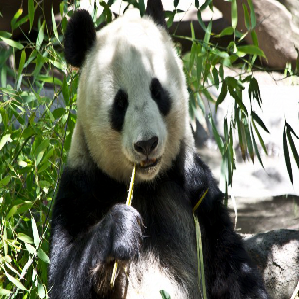

In [19]:
min_L1 = 1
for atk_method in attacks:
    # perform adversarial
    adv_image = generate_adversarial(
        model50,
        atk_method,
        criterion,
        initial_image
    )
    # get L1 norm
    diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)
    L1_norm = np.abs(diff).mean()
    # save lowest 
    if L1_norm < min_L1:
        min_L1 = L1_norm
        adv_best = adv_image
        atk_best = atk_method

print(f"Best L1 {min_L1:.5f} with {atk_best}")
pred_class, label, probability = get_prediction(model50, adv_best)
print(f"Predicted class {pred_class}: {label} with probability {probability:.3f}")
adv_best

2. Maximize probability

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Best probability 0.98326 with <class 'foolbox.attacks.iterative_projected_gradient.SparseL1BasicIterativeAttack'>
Predicted class 666: mortar


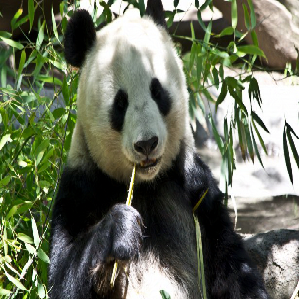

In [52]:
max_prob = 0
for atk_method in attacks:
    # perform adversarial
    adv_image = generate_adversarial(
        model50,
        atk_method,
        criterion, 
        initial_image
    )
    # get probability
    pred_class, label, probability = get_prediction(model50, adv_best)
    # save lowest 
    if probability > max_prob:
        max_prob = probability
        adv_best = adv_image
        atk_best = atk_method
        cls = pred_class
        lbl = label

print(f"Best probability {max_prob:.5f} with {atk_best}")
print(f"Predicted class {cls}: {lbl}")
adv_best

### Misclassification

In [0]:
attacks = [
           atk.SparseL1BasicIterativeAttack,
           atk.L2BasicIterativeAttack,
           atk.PGD, 
           atk.AdamPGD,
           atk.DeepFoolAttack,
           atk.NewtonFoolAttack,
           atk.SinglePixelAttack,
           atk.InversionAttack
]
criterion = Misclassification()

1. Minimize L1

Best L1 0.40428 with <class 'foolbox.attacks.iterative_projected_gradient.SparseL1BasicIterativeAttack'>
Predicted class 295: American black bear, black bear, Ursus americanus, Euarctos americanus with probability 0.433


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SinglePixelAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


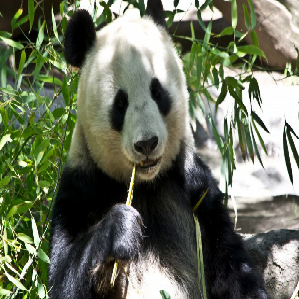

In [54]:
min_L1 = 1
for atk_method in attacks:
    # perform adversarial
    adv_image = generate_adversarial(
        model50,
        atk_method,
        criterion,
        initial_image
    )
    # get L1 norm
    diff = np.array(adv_image).astype(int) - np.array(initial_image).astype(int)
    L1_norm = np.abs(diff).mean()
    # save lowest 
    if L1_norm < min_L1:
        min_L1 = L1_norm
        adv_best = adv_image
        atk_best = atk_method

print(f"Best L1 {min_L1:.5f} with {atk_best}")
pred_class, label, probability = get_prediction(model50, adv_best)
print(f"Predicted class {pred_class}: {label} with probability {probability:.3f}")
adv_best

2. Maximize Probability

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SinglePixelAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


Best probability 0.98124 with <class 'foolbox.attacks.iterative_projected_gradient.SparseL1BasicIterativeAttack'>
Predicted class 666: mortar


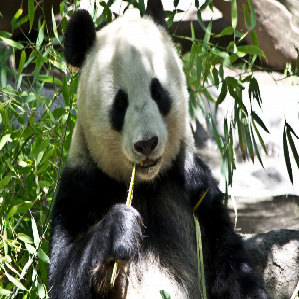

In [21]:
max_prob = 0
for atk_method in attacks:
    # perform adversarial
    adv_image = generate_adversarial(
        model50,
        atk_method,
        criterion, 
        initial_image
    )
    # get probability
    pred_class, label, probability = get_prediction(model50, adv_best)
    # save lowest 
    if probability > max_prob:
        max_prob = probability
        adv_best = adv_image
        atk_best = atk_method
        cls = pred_class
        lbl = label

print(f"Best probability {max_prob:.5f} with {atk_best}")
print(f"Predicted class {cls}: {lbl}")
adv_best